In [25]:
import numpy as np
import pandas as pd
from os import walk
from PIL import Image
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input, decode_predictions
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Activation
from tensorflow.keras.metrics import Accuracy
from keras.utils import np_utils

In [26]:
classes = ["Cat", "Dog", "Bird"]
base_path = '../fiftyone/open-images-v6/train/'
class_map = pd.read_csv(base_path + 'metadata/classes.csv', names=['id', 'name'])
class_map.head()

,id,name
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [27]:
mask = class_map['name'].isin(classes)
labels = {}
for index, row in class_map[mask].iterrows():
    labels[row['name']] = row['id']
labels

{'Bird': '/m/015p6', 'Cat': '/m/01yrx', 'Dog': '/m/0bt9lr'}

In [28]:
img_labels = pd.read_csv(base_path + 'labels/classifications.csv')
img_labels.head()

,ImageID,Source,LabelName,Confidence
0,000002b66c9c498e,verification,/m/014j1m,0
1,000002b66c9c498e,verification,/m/014sv8,1
2,000002b66c9c498e,verification,/m/01599,0
3,000002b66c9c498e,verification,/m/015p6,0
4,000002b66c9c498e,verification,/m/015x4r,0


In [29]:
img_labels = img_labels[img_labels['Confidence'] == 1]

In [30]:
mask = img_labels['LabelName'].isin(labels.values())
img_labels = img_labels[mask]

In [31]:
images = []
for (dirpath, dirnames, filenames) in walk(base_path + 'data'):
    images.append(filenames)
images = [i.split('.')[0] for i in images[0]]

In [32]:
mask = img_labels['ImageID'].isin(images)
img_labels = img_labels[mask]

In [33]:
img_labels

,ImageID,Source,LabelName,Confidence
950,000020780ccee28d,verification,/m/01yrx,1
2647,0000530c47410921,verification,/m/015p6,1
4100,0000862a233105cc,crowdsource-verification,/m/015p6,1
5171,0000b9fcba019d36,crowdsource-verification,/m/0bt9lr,1
5335,0000bf2838ee5aeb,crowdsource-verification,/m/0bt9lr,1
...,...,...,...,...
8943370,fe36ecce6ddb7188,crowdsource-verification,/m/0bt9lr,1
8943373,fe36ecce6ddb7188,verification,/m/01yrx,1
8948061,fe5ffe60204d2d86,verification,/m/0bt9lr,1
8962938,fedfc11152a1b135,verification,/m/015p6,1


In [34]:
img_labels.drop(['Confidence', 'Source'], axis=1,  inplace=True)

In [35]:
encoding = {k:v for v, k in enumerate(labels.values())}
encoding

{'/m/015p6': 0, '/m/01yrx': 1, '/m/0bt9lr': 2}

In [36]:
img_labels_final = img_labels.replace(encoding)
img_labels_final

,ImageID,LabelName
950,000020780ccee28d,1
2647,0000530c47410921,0
4100,0000862a233105cc,0
5171,0000b9fcba019d36,2
5335,0000bf2838ee5aeb,2
...,...,...
8943370,fe36ecce6ddb7188,2
8943373,fe36ecce6ddb7188,1
8948061,fe5ffe60204d2d86,2
8962938,fedfc11152a1b135,0


In [37]:
img_labels_final = img_labels_final.reset_index()

In [38]:
X_id = img_labels_final['ImageID'].to_numpy()
y = img_labels_final['LabelName'].to_numpy()

In [39]:
y = np_utils.to_categorical(y)
y[:8]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

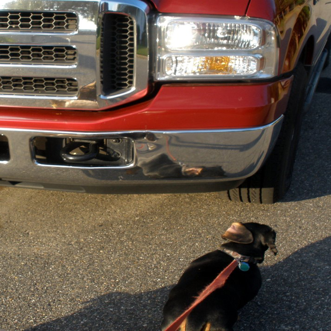

In [40]:
im = Image.open(base_path + 'data/' + X_id[4] + '.jpg')
im = im.resize(size=(331,331))
display(im)

In [41]:
def get_images(X_label, y):
    X = []
    Y = []
    for i, id in enumerate(X_label):
        im = Image.open(base_path + 'data/' + id + '.jpg')
        im = im.resize(size=(331,331))
        im = np.asarray(im)
        im_processed = preprocess_input(im)
        if im_processed.shape == (331, 331, 3):
            X.append(im_processed)
            Y.append(y[i])
    return np.array(X), np.array(Y)


In [42]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
base_model = NASNetLarge(weights='imagenet', include_top=True)

In [44]:
for layer in base_model.layers:
    layer.trainable = False

In [45]:
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [46]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3, activation='softmax'))

In [47]:
from sklearn.metrics import accuracy_score
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
batch_size = 200
for i in range(int(np.ceil(len(X_id)/200))):
    X = X_id[i: i + batch_size]
    Y = y[i: i + batch_size]
    X, Y = get_images(X, Y)
    model.fit(X, Y)

7/7 [==============================] - 45s 6s/step - loss: 0.4395 - accuracy: 0.0000e+00


In [53]:
X_test, Y_test = get_images(X_id[:20], y[:20])
score, acc = model.evaluate(X_test, Y_test)
print(score, acc)

1/1 [==============================] - 11s 11s/step - loss: 0.9644 - accuracy: 0.0000e+00
0.9643943905830383 0.0


In [49]:
# logits_layer = model.get_layer('predictions')
# model_logits = keras.Model(inputs=model.input, 
#                            outputs=logits_layer.output)

In [50]:
# def process_input(X, y):
#     d = dict(features=[], target=[])

#     for xi, yi in zip(X, y):
#         np_logits_pooled = model_logits.predict(np.array([xi]), verbose=1)[0]
            
#         d['features'].append(np_logits_pooled)
#         d['target'].append( yi )
#     return d

In [51]:
# from sklearn import svm
# train = process_input(X_train, y_train)
# classifier = svm.LinearSVC()
# classifier.fit(train['features'], train['target']) # learn from the data 

In [52]:
# test = process_input(X_test, y_test)
# classifier.score(test['features'], test['target'])